In [1]:
# Fundamental classes
import numpy as np 
import pandas as pd 
import tensorflow as tf
import os

# Image related
import cv2
from PIL import Image

#Performance Plot
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For the model and it's training
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

# Time
import time
import datetime

2023-01-28 00:24:20.353450: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-28 00:24:21.221486: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-28 00:24:21.221567: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-28 00:24:21.221577: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()

In [3]:
def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

In [4]:
data = []
labels = []
classes = 43
cur_path = os.getcwd()

# Retrieving the images and their labels 
for i in range(classes):
    path = os.path.join('archive','train',str(i))
    images = os.listdir(path)

    for a in images:
        try:
            image = Image.open(path + '/'+ a)
            image = image.resize((30,30))
            image = np.array(image)
            #sim = Image.fromarray(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")

# Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)


In [5]:
# Checking data shape
print(data.shape, labels.shape)

# Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Displaying the shape after the split
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)



(39209, 30, 30, 3) (39209,)
(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


In [12]:
# Building the model
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.15))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.15))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(43, activation='softmax'))

# Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#M odel display
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 64)        4864      
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 64)        102464    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 11, 11, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 9, 9, 64)          36928     
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 64)          36928     
                                                      

In [13]:
with tf.device('/GPU:0'):
    epochs = 30
    history1 = model.fit(X_train, y_train, batch_size=64, epochs=epochs, validation_data=(X_test, y_test))


Epoch 1/30
490/491 [============================>.] - ETA: 0s - loss: 1.4680 - accuracy: 0.6485

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

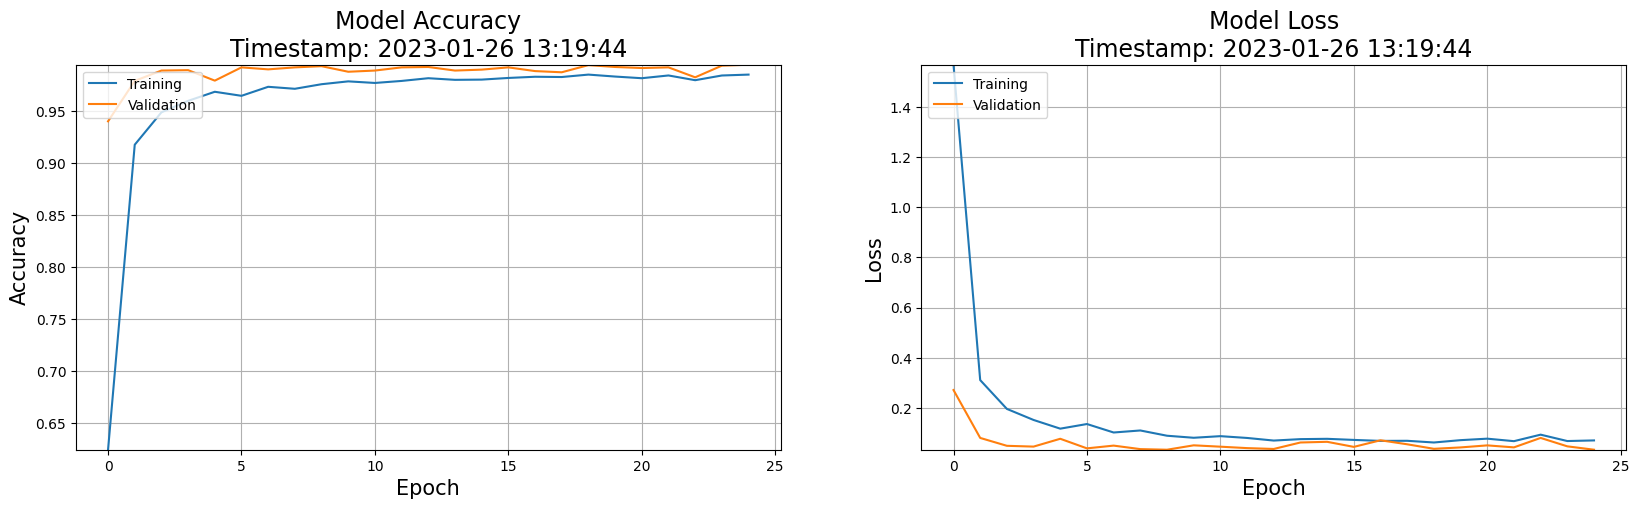

In [11]:
plot_performance(history=history1)

In [7]:
# testing accuracy on test dataset
from sklearn.metrics import accuracy_score

# Importing the test dataset
y_test = pd.read_csv('/home/monijesu/Documents/Project/Test.csv')

labels = y_test["ClassId"].values
imgs = y_test["Path"].values

data=[]

# Retreiving the images
with tf.device('/GPU:0'):
    for img in imgs:
        image = Image.open('/home/monijesu/Documents/Project/archive/'+img)
        image = image.resize([30, 30])
        data.append(np.array(image))

X_test=np.array(data)

2023-01-28 00:25:29.070529: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2023-01-28 00:25:29.070567: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: monijesu-Swift-SF315-52G
2023-01-28 00:25:29.070576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: monijesu-Swift-SF315-52G
2023-01-28 00:25:29.070730: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.108.3
2023-01-28 00:25:29.070760: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.60.11
2023-01-28 00:25:29.070768: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 525.60.11 does not match DSO version 510.108.3 -- cannot find working devices in t

In [8]:
with tf.device('/GPU:0'):
    pred = np.argmax(model.predict(X_test), axis=-1)

#Accuracy with the test data
from sklearn.metrics import accuracy_score
print(accuracy_score(labels, pred))

NameError: name 'model' is not defined

In [25]:
from tensorflow.keras.models import model_from_json
model_json = model.to_json()
with open("modeli.json", "w") as json_file:
    json_file.write(model_json)

print("json model saved to disk")

json model saved to disk


In [26]:
model.save("modeli.h5")
print("h5 model saved to disk")

h5 model saved to disk


In [6]:
modeli.summary()

NameError: name 'modeli' is not defined